***

**Exploration graphique**

***

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as mno
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

import xgboost as xgb
#import lightgbm as lgb

from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, \
                                    StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, \
                            precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder

from pprint import pprint

from vecstack import StackingTransformer

RANDOM_STATE = 1805

In [0]:
training_set = pd.read_csv('data/ref_train_x.csv')
testing_set = pd.read_csv('data/ref_test_x.csv')
labels = pd.read_csv('data/ref_train_y.csv', header=None)

In [0]:
print(training_set.shape)
print(testing_set.shape)
print(labels.shape)

(15249, 23)
(4191, 23)
(15249, 1)


In [0]:
training_set.head()

,raw_id,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,...,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio
0,2c1d2f99-b9c4-4541-8639-283ce4a20151,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,...,364.0,US,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241
1,97049514-254d-4c3c-82c3-b1bb0a6117fe,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,...,66.0,US,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581
2,0f353f95-54d1-4a03-9099-06eea9981365,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,...,255.0,US,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581
3,b74cc12f-0582-415d-83c5-a8ee64783c60,4700,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,...,358.0,US,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581
4,d68889cd-6018-436b-a6b3-558fe9dbc78a,4700,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,...,62.0,US,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581


For starting:

In [0]:
%%time
X = training_set.set_index('raw_id').copy()
y = labels.set_index(training_set['raw_id'])
dataset = pd.concat([X, y], axis=1)

CPU times: user 12.6 ms, sys: 5.03 ms, total: 17.7 ms
Wall time: 15.7 ms


In [0]:
dataset = dataset.rename(columns={0: "y"})

# Data Exploration

**Sector**

''

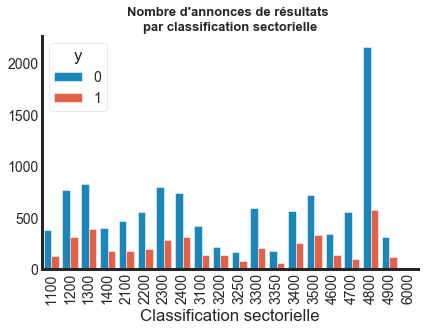

In [0]:
sns.set_style("white")
p = sns.countplot(x="sector", hue="y", data=dataset)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.title("Nombre d'annonces de résultats \npar classification sectorielle", fontsize=13, fontweight='bold')
plt.xlabel("Classification sectorielle")
plt.ylabel("")
sns.despine();

--> effet de la classification sectorielle sur y<br>
--> pour imputer les NA, on peut imputer les NA d'une classe par la moyenne de la classe

**earnings_implied_obs**

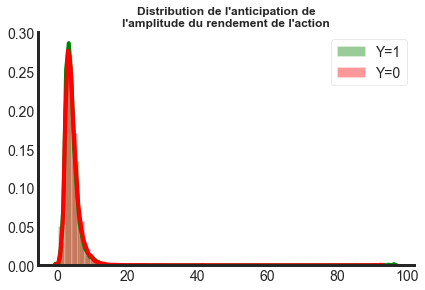

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["earnings_implied_obs"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["earnings_implied_obs"].values, color="red", label="Y=0")
plt.title("Distribution de l'anticipation de\nl'amplitude du rendement de l'action", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**delta_vol_1w**

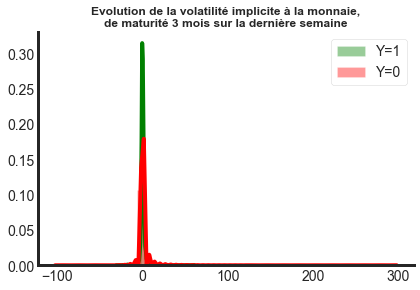

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["delta_vol_1w"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["delta_vol_1w"].values, color="red", label="Y=0")
plt.title("Evolution de la volatilité implicite à la monnaie,\nde maturité 3 mois sur la dernière semaine", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**delta_vol_1y**

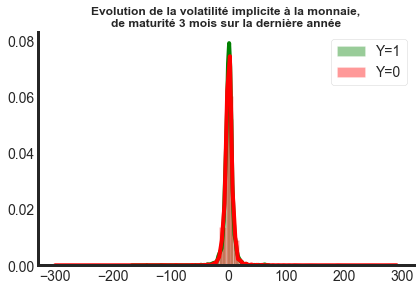

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["delta_vol_1y"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["delta_vol_1y"].values, color="red", label="Y=0")
plt.title("Evolution de la volatilité implicite à la monnaie,\nde maturité 3 mois sur la dernière année", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**return_1w**

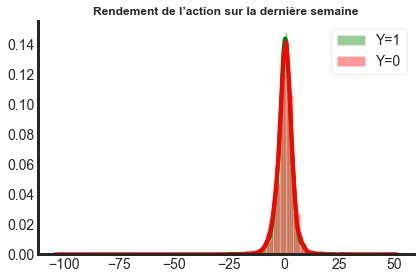

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["return_1w"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["return_1w"].values, color="red", label="Y=0")
plt.title("Rendement de l’action sur la dernière semaine", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**return_1m**

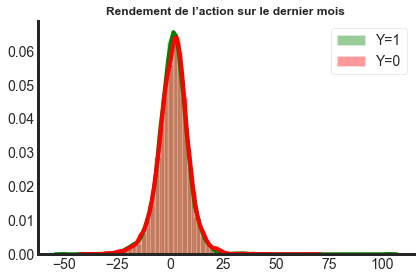

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["return_1m"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["return_1m"].values, color="red", label="Y=0")
plt.title("Rendement de l’action sur le dernier mois", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**return_1y**

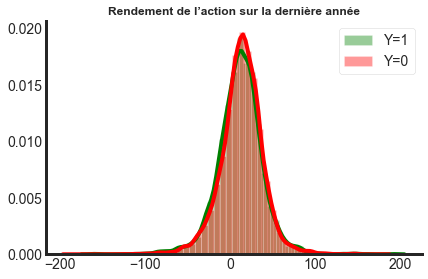

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["return_1y"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["return_1y"].values, color="red", label="Y=0")
plt.title("Rendement de l’action sur la dernière année", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**implied_vol_3m**

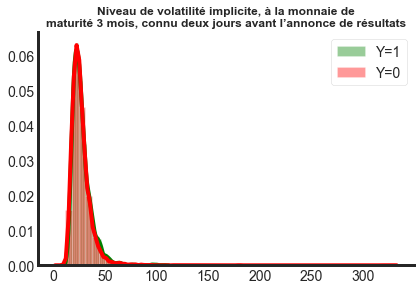

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["implied_vol_3m"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["implied_vol_3m"].values, color="red", label="Y=0")
plt.title("Niveau de volatilité implicite, à la monnaie de\nmaturité 3 mois, connu deux jours avant l’annonce de résultats", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**realised_vol_1w**

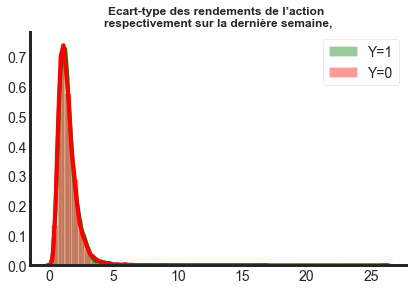

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["realised_vol_1w"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["realised_vol_1w"].values, color="red", label="Y=0")
plt.title("Ecart-type des rendements de l’action \nrespectivement sur la dernière semaine,", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**realised_vol_1m**

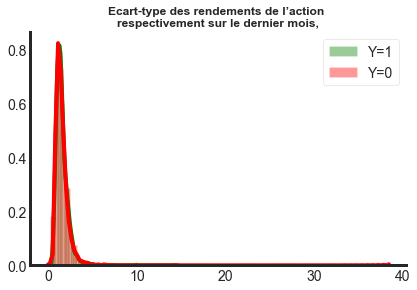

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["realised_vol_1m"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["realised_vol_1m"].values, color="red", label="Y=0")
plt.title("Ecart-type des rendements de l’action \nrespectivement sur le dernier mois,", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**realised_vol_1y**

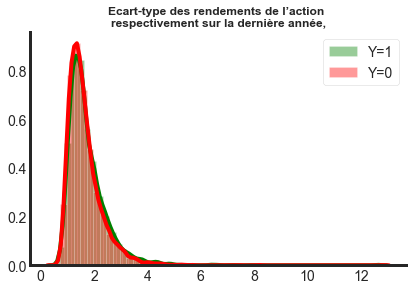

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["realised_vol_1y"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["realised_vol_1y"].values, color="red", label="Y=0")
plt.title("Ecart-type des rendements de l’action \nrespectivement sur la dernière année,", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**ratio_put_call**

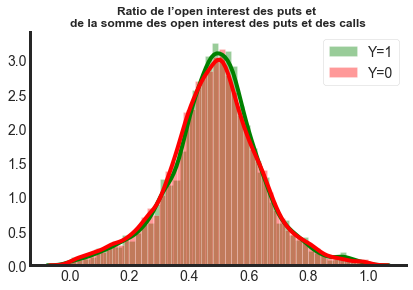

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["ratio_put_call"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["ratio_put_call"].values, color="red", label="Y=0")
plt.title("Ratio de l’open interest des puts et \nde la somme des open interest des puts et des calls", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**publication_date_funda**

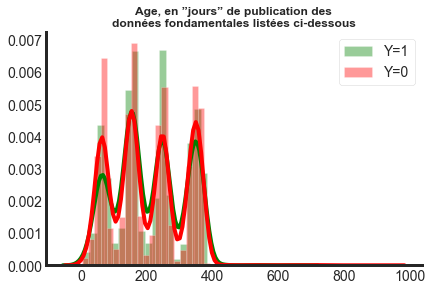

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["publication_date_funda"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["publication_date_funda"].values, color="red", label="Y=0")
plt.title("Age, en ”jours” de publication des\ndonnées fondamentales", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**exchange**

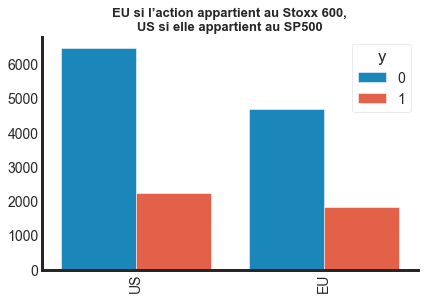

In [0]:
sns.set_style("white")
p = sns.countplot(x="exchange", hue="y", data=dataset)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.title("EU si l’action appartient au Stoxx 600,\nUS si elle appartient au SP500", fontsize=13, fontweight='bold')
plt.xlabel("")
plt.ylabel("")
sns.despine();

**net_income**

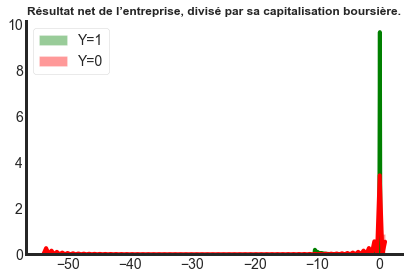

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["net_income"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["net_income"].values, color="red", label="Y=0")
plt.title("Résultat net de l’entreprise, divisé par sa capitalisation boursière.", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

In [0]:
dataset["net_income"]

raw_id
2c1d2f99-b9c4-4541-8639-283ce4a20151    0.018193
97049514-254d-4c3c-82c3-b1bb0a6117fe    0.065461
0f353f95-54d1-4a03-9099-06eea9981365    0.065711
b74cc12f-0582-415d-83c5-a8ee64783c60    0.064607
d68889cd-6018-436b-a6b3-558fe9dbc78a   -0.111328
                                          ...   
06aee79f-fabb-4c0f-bbbc-26f91c59eb7d    0.033829
71f78c76-f38c-46a3-b808-299f6f9ce55e    0.037577
8158ff94-a3be-4395-b734-644e76af1a4b    0.019151
7bda3183-a7cc-4d83-a259-08e846bc875d    0.021931
15d3e4ec-fa29-4bd7-9a61-a91160b0991f    0.019874
Name: net_income, Length: 15249, dtype: float64

**shareholders_equity**

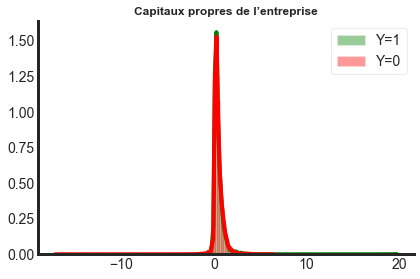

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["shareholders_equity"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["shareholders_equity"].values, color="red", label="Y=0")
plt.title("Capitaux propres de l’entreprise", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**net_debt**

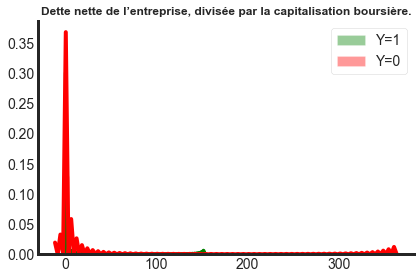

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["net_debt"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["net_debt"].values, color="red", label="Y=0")
plt.title("Dette nette de l’entreprise, divisée par la capitalisation boursière.", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**ebitda**

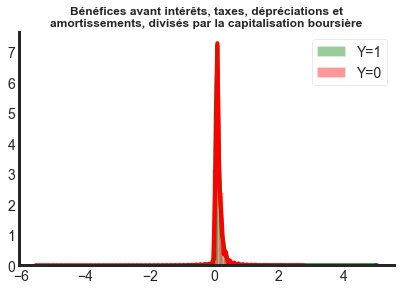

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["ebitda"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["ebitda"].values, color="red", label="Y=0")
plt.title("Bénéfices avant intérêts, taxes, dépréciations et\namortissements, divisés par la capitalisation boursière", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**ebit**

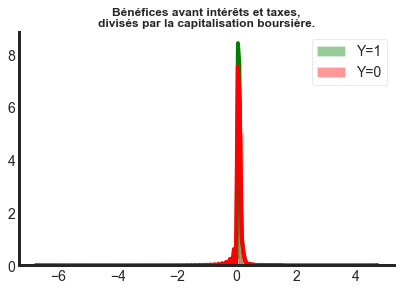

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["ebit"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["ebit"].values, color="red", label="Y=0")
plt.title("Bénéfices avant intérêts et taxes,\ndivisés par la capitalisation boursière.", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**sales**

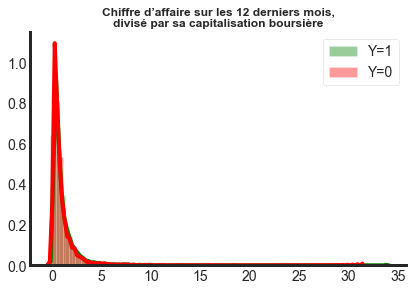

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["sales"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["sales"].values, color="red", label="Y=0")
plt.title("Chiffre d’affaire sur les 12 derniers mois,\ndivisé par sa capitalisation boursière", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

**cash_flow**

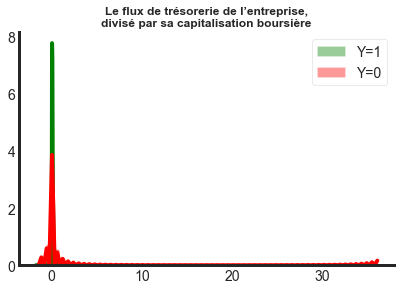

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["cash_flow"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["cash_flow"].values, color="red", label="Y=0")
plt.title("Le flux de trésorerie de l’entreprise,\ndivisé par sa capitalisation boursière", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

In [0]:
dataset.columns

Index(['sector', 'earnings_implied_obs', 'delta_vol_1w', 'delta_vol_1y',
       'return_1w', 'return_1m', 'return_1y', 'implied_vol_3m',
       'realised_vol_1w', 'realised_vol_1m', 'realised_vol_1y',
       'ratio_put_call', 'publication_date_funda', 'exchange', 'net_income',
       'shareholders_equity', 'net_debt', 'ebitda', 'ebit', 'sales',
       'cash_flow', 'payout_ratio', 'y'],
      dtype='object')

**payout_ratio**

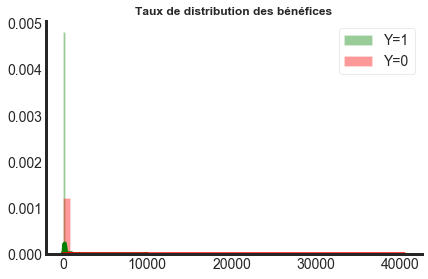

In [0]:
sns.distplot(dataset.iloc[np.where(dataset["y"] == 1)[
             0]]["payout_ratio"].values, color="green", label="Y=1")
sns.distplot(dataset.iloc[np.where(dataset["y"] == 0)[
             0]]["payout_ratio"].values, color="red", label="Y=0")
plt.title("Taux de distribution des bénéfices", fontweight="bold", fontsize=12);
plt.legend()
sns.despine();

In [0]:
dataset["payout_ratio"].value_counts()

0.000000      2267
50.000000       28
33.333333       24
42.082285       24
83.333333       22
              ... 
874.855156       1
34.631148        1
18.333333        1
88.495575        1
24.666667        1
Name: payout_ratio, Length: 5163, dtype: int64